In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime as dt
import requests, copy, json, re
from scipy import stats
from pprint import pprint
from bs4 import BeautifulSoup
from bball_ref_scraper import BBRefScraper
from bball_ref_id_generator import id_generator

In [2]:
plt.style.use('dark_background')

### Create Initial DataFrame from scraping http://www.prosportstransactions.com/

In [3]:
df_json = pd.read_json("../data/pst_nba_injuries_2020_2021.txt")
df = df_json.copy()
df.head(5)

,Date,Team,Healed,Injured,Notes
0,2020-03-11,76ers,Joel Embiid,,activated from IL
1,2020-03-11,Bucks,Eric Bledsoe,,activated from IL
2,2020-03-11,Bucks,George Hill,,activated from IL
3,2020-03-11,Bulls,,Chandler Hutchison,surgery on right shoulder (out for season)
4,2020-03-11,Heat,,Jimmy Butler,placed on IL with left big toe injury


### Reformat the DataFrame

In [4]:

df['Player'] = df['Healed'] + df['Injured']
df['Status'] = np.where(df['Healed'] == '', 'Injured', 'Healed')
df = df[['Date', 'Team', 'Player', 'Status', 'Notes']]
df.head(10)

,Date,Team,Player,Status,Notes
0,2020-03-11,76ers,Joel Embiid,Healed,activated from IL
1,2020-03-11,Bucks,Eric Bledsoe,Healed,activated from IL
2,2020-03-11,Bucks,George Hill,Healed,activated from IL
3,2020-03-11,Bulls,Chandler Hutchison,Injured,surgery on right shoulder (out for season)
4,2020-03-11,Heat,Jimmy Butler,Injured,placed on IL with left big toe injury
5,2020-03-11,Heat,Jae Crowder,Healed,returned to lineup
6,2020-03-11,Heat,Tyler Herro,Healed,activated from IL
7,2020-03-11,Hornets,Terry Rozier,Injured,placed on IL with illness
8,2020-03-11,Jazz,Emmanuel Mudiay,Injured,illness (DTD)
9,2020-03-11,Jazz,Rudy Gobert,Injured,COVID-19 coronavirus (out indefinitely)


### Extract players out for COVID or "Health and Safety Protocols"

In [5]:
df_cv19 = df[np.logical_or(df['Notes'].str.contains('COVID'), df['Notes'].str.contains('protocol'))]
df_cv19

,Date,Team,Player,Status,Notes
9,2020-03-11,Jazz,Rudy Gobert,Injured,COVID-19 coronavirus (out indefinitely)
19,2020-03-12,Jazz,Donovan Mitchell,Injured,COVID-19 coronavirus (DTD)
21,2020-03-14,Pistons,Christian Wood,Injured,COVID-19 coronavirus (DTD)
22,2020-03-17,Nets,Kevin Durant,Injured,NBA health and safety protocols (DTD)
24,2020-03-19,Celtics,Marcus Smart,Injured,COVID-19 coronavirus (out indefinitely)
...,...,...,...,...,...
2846,2021-05-09,Pistons,Hamidou Diallo,Injured,placed on IL with NBA health and safety protocols
2957,2021-05-14,Thunder,Josh Hall,Injured,placed on IL with NBA health and safety protoc...
2969,2021-05-15,Heat,Omer Yurtseven,Injured,placed on IL with NBA health and safety protocols
3031,2021-05-16,Spurs,DaQuan Jeffries,Injured,placed on IL with NBA health and safety protoc...


240 instances of players being held out due to COVID protocols since 03/11/2020 (The day Rudy Gobert tested positive and the league shut down)

### Just COVID data for 2020-2021 NBA Season

In [6]:
df_cv19_2021 = df_cv19[df_cv19['Date'] >= '12-01-2020']
df_cv19_2021

,Date,Team,Player,Status,Notes
415,2020-12-22,Blazers,Nassir Little,Injured,COVID-19 (DTD)
423,2020-12-22,Hawks,Rajon Rondo,Injured,placed on IL with NBA health and safety protocols
468,2020-12-23,Rockets,Kenyon Martin Jr. / K.J. Martin,Injured,placed on IL with NBA health and safety protocols
472,2020-12-25,Bucks,Mamadi Diakite,Injured,placed on IL with NBA health and safety protoc...
475,2020-12-25,Rockets,Ben McLemore,Injured,COVID-19 protocols
...,...,...,...,...,...
2846,2021-05-09,Pistons,Hamidou Diallo,Injured,placed on IL with NBA health and safety protocols
2957,2021-05-14,Thunder,Josh Hall,Injured,placed on IL with NBA health and safety protoc...
2969,2021-05-15,Heat,Omer Yurtseven,Injured,placed on IL with NBA health and safety protocols
3031,2021-05-16,Spurs,DaQuan Jeffries,Injured,placed on IL with NBA health and safety protoc...


230 instances of players being held out due to COVID protocols during 2020-2021 NBA season

### Unique Players

In [7]:
players = df_cv19_2021['Player'].unique()
len(players)

182

182 Unique Players were held out due to COVID protocols during 2020-2021 NBA season

### Generate basketball-reference.com IDs

In [8]:
bbref_id_list = []
for player in players:
    bbref_id = id_generator(player)
    if isinstance(bbref_id, tuple):
        print('Something messed up')
    else:
        bbref_id_list.append([player, bbref_id])

In [9]:
df_bbref_id = pd.DataFrame(bbref_id_list, columns=['Player', 'BBRef_ID'])
df_bbref_id

,Player,BBRef_ID
0,Nassir Little,littlna01
1,Rajon Rondo,rondora01
2,Kenyon Martin Jr. / K.J. Martin,martike04
3,Mamadi Diakite,diakima01
4,Ben McLemore,mclembe01
...,...,...
177,Luca Vildoza,vildolu01
178,Hamidou Diallo,diallha01
179,Omer Yurtseven,yurtsom01
180,DaQuan Jeffries,jeffrda01


### Merging BBRef IDs with DataFrame

In [10]:
df_main = pd.merge(left=df_cv19_2021, right=df_bbref_id, how='left', left_on=df_cv19_2021.Player, right_on=df_bbref_id.Player).drop("key_0", axis=1).drop('Player_y', axis=1)
df_main.rename(columns={'Player_x':'Player'}, inplace=True)
df_main

,Date,Team,Player,Status,Notes,BBRef_ID
0,2020-12-22,Blazers,Nassir Little,Injured,COVID-19 (DTD),littlna01
1,2020-12-22,Hawks,Rajon Rondo,Injured,placed on IL with NBA health and safety protocols,rondora01
2,2020-12-23,Rockets,Kenyon Martin Jr. / K.J. Martin,Injured,placed on IL with NBA health and safety protocols,martike04
3,2020-12-25,Bucks,Mamadi Diakite,Injured,placed on IL with NBA health and safety protoc...,diakima01
4,2020-12-25,Rockets,Ben McLemore,Injured,COVID-19 protocols,mclembe01
...,...,...,...,...,...,...
225,2021-05-09,Pistons,Hamidou Diallo,Injured,placed on IL with NBA health and safety protocols,diallha01
226,2021-05-14,Thunder,Josh Hall,Injured,placed on IL with NBA health and safety protoc...,halljo01
227,2021-05-15,Heat,Omer Yurtseven,Injured,placed on IL with NBA health and safety protocols,yurtsom01
228,2021-05-16,Spurs,DaQuan Jeffries,Injured,placed on IL with NBA health and safety protoc...,jeffrda01


### Scrape 

In [11]:
!pwd 


/Users/mbun/Code/dsi_galvanize/capstones/capstone_1/NBA-COVID-19-Investigation/code


```
for player, bbr_id in bbref_id_list:
    print(player)
    game_log = BBRefScraper(bbr_id).game_log_scraper(2021)
    filename = f'../data/game_logs/{bbr_id}_gamelog_2020_2021.txt'
    with open(filename, 'w') as outfile:
        json.dump(game_log, outfile)
```

In [12]:
random_bbrid = 'reedpa01'
list(df_main[df_main['BBRef_ID'] == random_bbrid]['Date'])
test_df['STL']

NameError: name 'test_df' is not defined

(0.0, 48.0)

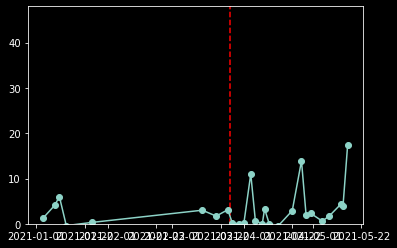

In [13]:
test_df = pd.read_json(f'../data/game_logs/{random_bbrid}_gamelog_2020_2021.txt').dropna()
# test_df[test_df['Date'] < '2021-03-26'].dropna().describe()
test_df['MP'] = pd.to_datetime(test_df['MP'], format='%M:%S')
test_df['MP'] = test_df['MP'].dt.minute + test_df['MP'].dt.second/60

plt.plot(test_df['Date'], test_df['GmSc'], marker='o')
plt.vlines(dt.date(2021, 3, 26), 0, 48, color='red', ls='--')
plt.ylim([0,48])

In [14]:
gby_player = df_cv19_2021.groupby('Player')

In [15]:
counts = gby_player.count()
# list(counts[counts['Date'] == 1].index)
df_cv19_2021.loc[['2020-12-22'], ['Nassir Little']]

KeyError: "None of [Index(['2020-12-22'], dtype='object')] are in the [index]"

In [16]:
gmlog_stats = ['MP', #'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB', 
               'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-']


In [127]:
return_date_list = []
for lst in bbref_id_list:
    player, bbrid = lst[0], lst[1]
    gmlog_df = pd.read_json(f'../data/game_logs/{bbrid}_gamelog_2020_2021.txt').dropna()
    gmlog_df['MP'] = pd.to_datetime(gmlog_df['MP'], format='%M:%S')
    gmlog_df['MP'] = gmlog_df['MP'].dt.minute + round(gmlog_df['MP'].dt.second/60, 2)
    cv19dates = list(df_main[df_main['BBRef_ID'] == bbrid]['Date'])
    for i, cv19date in enumerate(cv19dates):
        before_cv19 = gmlog_df[gmlog_df['Date'] <= cv19date]
        after_cv19 = gmlog_df[gmlog_df['Date'] > cv19date]
        # if (before_cv19['G'].count() >= 5) or (after_cv19['G'].count() >= 5):
        mp_before = before_cv19['MP'][:5].mean()
        mp_after = after_cv19['MP'][:5].mean()

        gmsc_before = before_cv19['GmSc'][:5].mean()
        gmsc_after = after_cv19['GmSc'][:5].mean()

        gmsc_rate_before = (before_cv19['GmSc']/before_cv19['MP'])[:5].mean()
        gmsc_rate_after = (after_cv19['GmSc']/after_cv19['MP'])[:5].mean()
        bcv19_count = before_cv19['G'].count()
        acv19_count = after_cv19['G'].count()
        returned_date = after_cv19['Date'].min()
        if (len(cv19dates) > 1) and (len(cv19dates) != i+1):
            if cv19dates[i+1] < returned_date:
                returned_date = pd.NaT
            # time_out = (returned_date - cv19date).days
        return_date_list.append([bbrid, cv19date, returned_date, bcv19_count, acv19_count, mp_before, mp_after, gmsc_before, gmsc_after, gmsc_rate_before, gmsc_rate_after])
        # print([bbrid, cv19date, returned_date])
            # print(player,cv19date.date(),returned_date.date(), time_out, bcv19_count, acv19_count)
df_return = pd.DataFrame(return_date_list, columns=['bbrid', 'out_date', 'Return_Date', 'Games_Before', 'Games_After', 'MP_5_Before', 'MP_5_After', 'GmSc_5_Before', 'GmSc_5_After', 'GmSc/MP_5_Before', 'GmSc/MP_5_After'])
df_return['Return_Date'] = df_return['Return_Date'].astype('datetime64')
df_return['out_date'] = df_return['out_date'].astype('datetime64')

df_return.tail(30)

,bbrid,out_date,Return_Date,Games_Before,Games_After,MP_5_Before,MP_5_After,GmSc_5_Before,GmSc_5_After,GmSc/MP_5_Before,GmSc/MP_5_After
200,thomais02,2021-04-04,2021-04-06,0,3,NaN,16.090000,NaN,2.200000,NaN,0.154213
201,brookar01,2021-04-04,2021-04-09,0,21,NaN,15.648000,NaN,6.020000,NaN,0.269134
202,theisda01,2021-04-05,2021-04-08,48,20,21.096,24.258000,5.44,11.340000,0.273740,0.448234
203,harrish01,2021-04-09,2021-04-16,18,18,4.494,13.412000,1.40,2.660000,0.227846,0.200577
204,mckinal01,2021-04-12,2021-04-13,33,8,2.910,9.182000,2.48,3.980000,0.799221,0.357816
205,deckga01,2021-04-12,2021-04-29,0,10,NaN,19.360000,NaN,8.520000,NaN,0.455277
206,tollian01,2021-04-12,2021-04-16,0,11,NaN,12.442000,NaN,1.000000,NaN,0.150230
207,lavinza01,2021-04-15,2021-05-06,55,5,32.418,33.360000,14.48,17.940000,0.432080,0.519567
208,burksal01,2021-04-16,2021-05-03,46,5,28.164,24.086000,11.66,10.120000,0.431584,0.358528
209,claxtni01,2021-04-19,2021-05-04,26,7,15.118,16.764000,10.20,7.280000,0.636601,0.363808


In [128]:
df_main_dates = pd.merge(df_main, df_return, how='left', left_on=['Date', 'BBRef_ID'], right_on=['out_date', 'bbrid']).drop(['bbrid', 'out_date'], axis=1).dropna()
df_main_dates['Days_Out'] = df_main_dates['Return_Date'] - df_main_dates['Date']
df_min_games = df_main_dates[np.logical_and(df_main_dates['Games_Before'] >= 5, df_main_dates['Games_After'] >= 5)].copy()
df_min_games['MP_Diff'] = df_min_games['MP_5_After'] - df_min_games['MP_5_Before']
df_min_games['GmSc_Diff'] = df_min_games['GmSc_5_After'] - df_min_games['GmSc_5_Before']
df_min_games['GmSc/MP_Diff'] = df_min_games['GmSc/MP_5_After'] - df_min_games['GmSc/MP_5_Before']
df_min_games

,Date,Team,Player,Status,Notes,BBRef_ID,Return_Date,Games_Before,Games_After,MP_5_Before,MP_5_After,GmSc_5_Before,GmSc_5_After,GmSc/MP_5_Before,GmSc/MP_5_After,Days_Out,MP_Diff,GmSc_Diff,GmSc/MP_Diff
18,2021-01-04,Nets,Kevin Durant,Injured,placed on IL with NBA health and safety protocols,duranke01,2021-01-10,6,30,33.426,35.926,22.58,26.50,0.683524,0.735852,6 days,2.500,3.92,0.052329
25,2021-01-08,76ers,Seth Curry,Injured,placed on IL with COVID-19,curryse01,2021-01-22,8,52,28.792,26.524,12.86,6.50,0.447689,0.249057,14 days,-2.268,-6.36,-0.198632
26,2021-01-08,Celtics,Grant Williams,Injured,placed on IL with NBA health and safety protocols,willigr01,2021-01-15,8,58,16.372,17.282,2.22,0.10,0.150621,0.012091,7 days,0.910,-2.12,-0.138530
27,2021-01-08,Celtics,Robert Williams III,Injured,placed on IL with COVID-19,williro04,2021-01-22,8,46,15.802,14.388,8.08,7.24,0.480830,0.469826,14 days,-1.414,-0.84,-0.011004
28,2021-01-08,Celtics,Tristan Thompson,Injured,placed on IL with NBA health and safety protocols,thomptr01,2021-01-15,8,48,23.696,23.196,8.06,3.14,0.333979,0.140774,7 days,-0.500,-4.92,-0.193206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2021-04-23,Nets,Alize Johnson,Injured,placed on IL with NBA health and safety protocols,johnsal02,2021-04-29,12,7,14.978,17.588,9.30,12.26,0.522678,0.599258,6 days,2.610,2.96,0.076579
212,2021-04-23,Warriors,Kent Bazemore,Injured,placed on IL with NBA health and safety protocols,bazemke01,2021-04-29,59,10,13.742,30.594,3.52,6.90,0.159668,0.225889,6 days,16.852,3.38,0.066220
213,2021-04-24,76ers,Paul Reed,Injured,placed on IL with NBA health and safety protocols,reedpa01,2021-04-26,18,8,11.052,5.536,2.26,4.08,0.254267,0.612739,2 days,-5.516,1.82,0.358472
217,2021-04-30,Pistons,Jahlil Okafor,Injured,placed on IL with NBA health and safety protocols,okafoja01,2021-05-04,22,7,11.416,14.602,4.98,4.86,0.478029,0.333082,4 days,3.186,-0.12,-0.144947


count                          128
mean               9 days 05:26:15
std      7 days 03:04:07.981548980
min                1 days 00:00:00
25%                3 days 00:00:00
50%                7 days 00:00:00
75%               15 days 00:00:00
max               29 days 00:00:00
Name: Days_Out, dtype: object

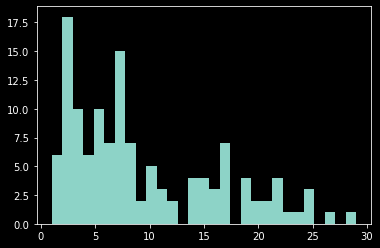

In [21]:
plt.hist(df_min_games['Days_Out'].dt.days, bins=29)
df_min_games['Days_Out'].describe()

count    128.000000
mean       0.816719
std        3.915432
min       -9.680000
25%       -1.690000
50%        0.560000
75%        3.140000
max       10.620000
Name: GmSc_Diff, dtype: float64

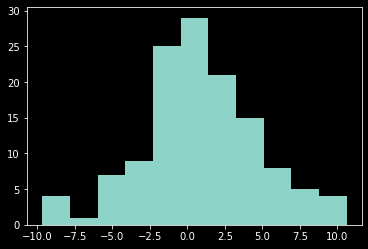

In [129]:
plt.hist(df_min_games['GmSc_Diff'], bins=11)
df_min_games['GmSc_Diff'].describe()

<AxesSubplot:>

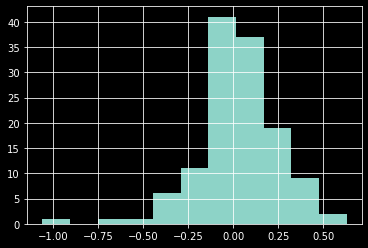

In [133]:
# plt.hist(df_min_games['GmSc/MP_Diff'], bins=11)
df_min_games['GmSc/MP_Diff'].hist(bins=11)

In [105]:
def one_dim_scatterplot(data, ax, jitter=0.2, **options):
    ## why jitter? especially for bootstraping later
    if jitter:
        jitter = np.random.uniform(-jitter, jitter, size=data.shape)
    else:
        jitter = np.repeat(0.0, len(data))
    ax.scatter(data, jitter, **options)
    ax.yaxis.set_ticklabels([])
    ax.set_ylim([-1, 1])
    ax.tick_params(axis='both', which='major', labelsize=15)

In [ ]:
on

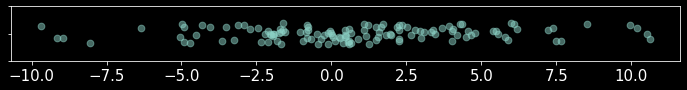

In [121]:
fig, ax = plt.subplots(1, figsize=(12, 1))
one_dim_scatterplot(df_min_games['GmSc_Diff'], ax, s=45, alpha=0.5)
# ax.scatter(df_min_games['GmSc_Diff'], np.repeat(0, len(df_min_games['GmSc_Diff'])) + np.random.normal(0, 0.1, len(df_min_games['GmSc_Diff'])), s=45)
# ax.set_yticks([-.5,0, .5])


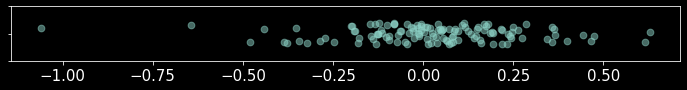

In [131]:
fig, ax = plt.subplots(1, figsize=(12, 1))
one_dim_scatterplot(df_min_games['GmSc/MP_Diff'], ax, s=45, alpha=0.5)

In [227]:
def analyze_data(data, data_name):
    print(data.describe(),"\n")
    data.plot.hist(bins=11, title=f"Distribution of {data_name}", xlabel=f"{data_name}", alpha=0.8)
    fig1, ax1 = plt.subplots(1, figsize=(12, 1))
    one_dim_scatterplot(data, ax1, s=45, alpha=0.5)
    ax1.set_title(f"1D Distribution of {data_name}")
    ax1.set_xlabel(data_name)
    data_sample_size, data_mean, data_std = data.count(), data.mean(), data.std()
    data_stderr = data_std / np.sqrt(data_sample_size)
    print(f"Sample Size of {data_name}:\t{data_sample_size}")
    print(f"Mean of {data_name}:\t\t{data_mean}")
    print(f"Std Dev of {data_name}:\t{data_std}")
    print(f"Std Error of {data_name}:\t{data_stderr}")
    print()

    fig2, ax2 = plt.subplots()
    t_dist = stats.t(loc=0, scale=data_stderr, df=data_sample_size-1)
    x2 = np.linspace(-1.5, 1.5, 100)
    ax2.set_title(f'Sample T-Distribution of {data_name}')
    ax2.plot(x, tt.pdf(x))
    ax2.vlines(data_mean,0, 1.2, color='r', ls='--')
    ax2.fill_between(x, tt.pdf(x), 0, where=(x<=tt.ppf(0.025)), color='C0', alpha=0.8)
    ax2.fill_between(x, tt.pdf(x), where=(x>=tt.ppf(0.975)), color='C0', alpha=0.8)
    ax2.legend(['T-Dist', 'Data Mean', '95% CI'])
    ax2.set_xlabel(data_name)
    ax2.set_ylabel("Density")
    ax2.set_ylim((0, 1.2))

    tstat, pval = stats.ttest_1samp(data, popmean=0)
    print(f"T-Statistic of {data_name}:\t{tstat}")
    print(f"p-value of {data_name}:\t{pval}")
    

count    128.000000
mean       0.024359
std        0.230298
min       -1.059469
25%       -0.095291
50%        0.025971
75%        0.159373
max        0.628605
Name: GmSc/MP_Diff, dtype: float64 

Sample Size of Difference in Mean Game Score Rate:	128
Mean of Difference in Mean Game Score Rate:		0.024358897411660432
Std Dev of Difference in Mean Game Score Rate:	0.23029840463699983
Std Error of Difference in Mean Game Score Rate:	0.02035569545190825

T-Statistic of Difference in Mean Game Score Rate:	1.196662500144493
p-value of Difference in Mean Game Score Rate:	0.23366725651432974


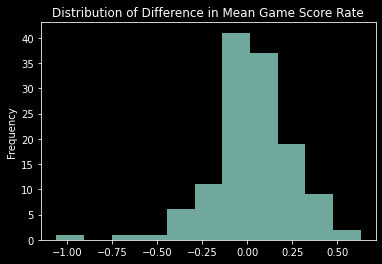

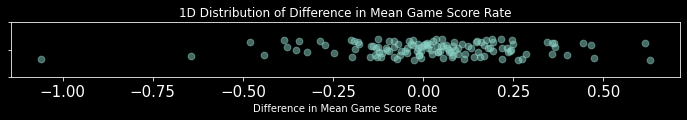

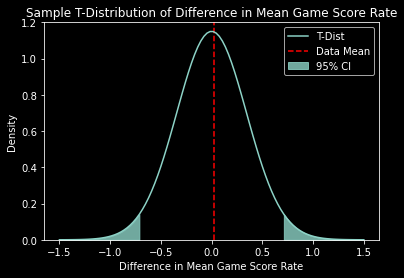

In [228]:
analyze_data(df_min_games['GmSc/MP_Diff'], 'Difference in Mean Game Score Rate')

In [216]:
sample_size_GmSc = df_min_games['GmSc_Diff'].count()
mean_of_mean_GmSc = df_min_games['GmSc_Diff'].mean()
std_of_mean_GmSc = df_min_games['GmSc_Diff'].std()
h0_pop_mean = 0
print(sample_size_GmSc, mean_of_mean_GmSc, std_of_mean_GmSc)

128 0.8167187499999997 3.915431837161349


In [217]:
tstat = mean_of_mean_GmSc / (std_of_mean_GmSc / np.sqrt(sample_size_GmSc))
tstat

2.359923055091212

In [218]:
stats.t(loc=0, scale=std_of_mean_GmSc / np.sqrt(sample_size_GmSc), df=sample_size_GmSc - 1).ppf(.975)
# stats.t(loc=0, scale=std_of_mean_GmSc / np.sqrt(sample_size_GmSc), df=sample_size_GmSc - 1).sf(abs(tstat))


0.6848269960977146

(0.0, 1.2)

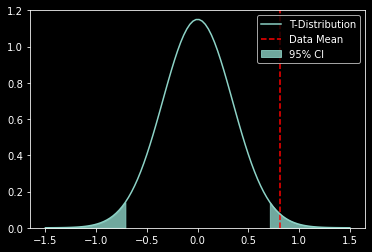

In [186]:
tt = stats.t(loc=0, scale=std_of_mean_GmSc / np.sqrt(sample_size_GmSc), df=sample_size_GmSc-1)
# plt.hist(df_min_games['GmSc_Diff'], bins=11, density=True)

x = np.linspace(-1.5, 1.5, 100)
plt.plot(x, tt.pdf(x))
plt.vlines(mean_of_mean_GmSc,0, 1.2, color='r', ls='--')
# plt.plot(x, normal_dist.pdf(x))
plt.fill_between(x, tt.pdf(x), 0, where=(x<=tt.ppf(0.025)), color='C0', alpha=0.8)
plt.fill_between(x, tt.pdf(x), where=(x>=tt.ppf(0.975)), color='C0', alpha=0.8)
plt.legend(['T-Distribution', 'Data Mean', '95% CI'])
plt.ylim((0, 1.2))

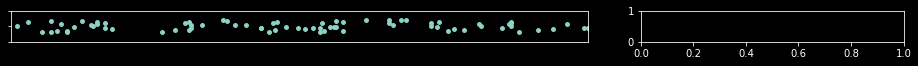

In [125]:
def bootstrap_function(data, n_bootstraps=10**4):
    bootstrap_sample_means = []
    for i in range(n_bootstraps):
        bootstrap_sample = np.random.choice(data, size=len(data), )

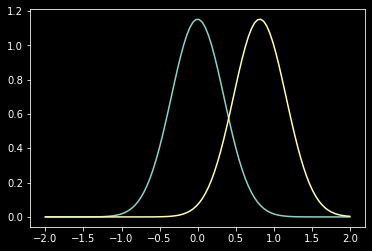

In [41]:
norm_GmSc = stats.norm(loc=mean_of_mean_GmSc, scale=(std_of_mean_GmSc/(np.sqrt(sample_size_GmSc))))
normal_dist = stats.norm(loc=h0_pop_mean, scale=(std_of_mean_GmSc/(np.sqrt(sample_size_GmSc))))
x = np.linspace(-2, 2, 100)
plt.plot(x, normal_dist.pdf(x))
plt.plot(x, norm_GmSc.pdf(x))



In [58]:
stats.ttest_1samp(df_min_games['GmSc_Diff'], popmean=0)

Ttest_1sampResult(statistic=2.359923055091212, pvalue=0.0198022763529891)

In [39]:
normal_dist.ppf(0.975)


0.6783014946377998

In [40]:
zstat = mean_of_mean_GmSc / std_of_mean_GmSc
zstat

0.20858969941668376

In [43]:
p_val_GmSc = normal_dist.sf(abs(zstat))*2
p_val_GmSc


0.5466925989353449

(count    72.000000
 mean      0.035027
 std       0.246879
 min      -1.059469
 25%      -0.063707
 50%       0.050157
 75%       0.162812
 max       0.628605
 Name: GmSc/MP_Diff, dtype: float64,
 count    56.000000
 mean      0.010643
 std       0.208441
 min      -0.480766
 25%      -0.109641
 50%       0.007367
 75%       0.142358
 max       0.613840
 Name: GmSc/MP_Diff, dtype: float64)

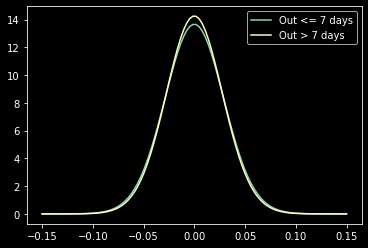

In [235]:
sample_1 = df_min_games[df_min_games['Days_Out'].dt.days <= 7]['GmSc/MP_Diff']
sample_2 = df_min_games[df_min_games['Days_Out'].dt.days > 7]['GmSc/MP_Diff']
sample_1_size = sample_1.count()
sample_2_size = sample_2.count()
norm_sample_1 = stats.t(loc=h0_pop_mean, scale=sample_1.std()/np.sqrt(sample_1_size), df=sample_1_size-1)
norm_sample_2 = stats.t(loc=h0_pop_mean, scale=sample_2.std()/np.sqrt(sample_2_size), df=sample_2_size-1)
# tt = stats.t(loc=0, scale=std_of_mean_GmSc / np.sqrt(sample_size_GmSc), df=sample_size_GmSc-1)
x = np.linspace(-0.15, 0.15, 100)
plt.plot(x, norm_sample_1.pdf(x))
plt.plot(x, norm_sample_2.pdf(x))
plt.legend(['Out <= 7 days', 'Out > 7 days'])
sample_1.describe(), sample_2.describe()

In [233]:
stats.ttest_ind(sample_1, sample_2)

Ttest_indResult(statistic=0.5927113156892524, pvalue=0.5544366358688246)

In [49]:
def two_sample_ztest(sample1, sample2, mu0=0):
    n1, n2 = sample1.count(), sample2.count()
    X1, X2 = sample1.mean(), sample2.mean()
    v1, v2 = sample1.var(), sample2.var()
    zstat = ((X1 - X2) - mu0) / np.sqrt((v1/n1) + (v2/n2))
    p_val = stats.norm(loc=mu0, scale=np.sqrt((v1/n1) + (v2/n2))).sf(abs(zstat))
    return zstat, p_val


In [232]:
import statsmodels.stats.weightstats as smsws
smsws.ztest(df_min_games['GmSc/MP_Diff']), smsws.ztest(sample_1, sample_2)

((1.196662500144493, 0.2314381289834364),
 (0.5927113156892524, 0.5533743672382381))

In [50]:
two_sample_ztest(sample_1, sample_2)

(2.5623568700750337, 0.00011410906106668669)

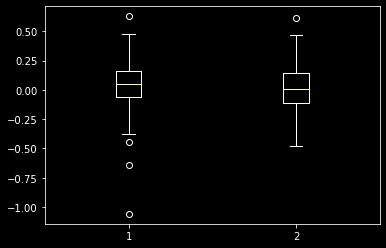

In [234]:
plt.boxplot([sample_1, sample_2]);

In [31]:
bbref_id_list = df_main_dates[['Player', 'BBRef_ID']].values.tolist()
b = []
[b.append([x,y]) for [x,y] in bbref_id_list if [x,y] not in b]
bbref_id_list = b

Nick Richards not Plotted
Vincent Poirier not Plotted
Terrance Ferguson not Plotted
Grant Riller not Plotted
Nate Darling not Plotted
Norvel Pelle not Plotted
Iman Shumpert not Plotted
Adam Mokoka not Plotted
Patrick McCaw not Plotted
Kostas Antetokounmpo not Plotted
Axel Toupane not Plotted
Devon Dotson not Plotted
Udonis Haslem not Plotted
Isaiah Thomas not Plotted
Anthony Tolliver not Plotted
Keljin Blevins not Plotted
Marcos Louzada Silva / Didi Louzada Silva not Plotted
Plotting MP Done, Saving Plot...


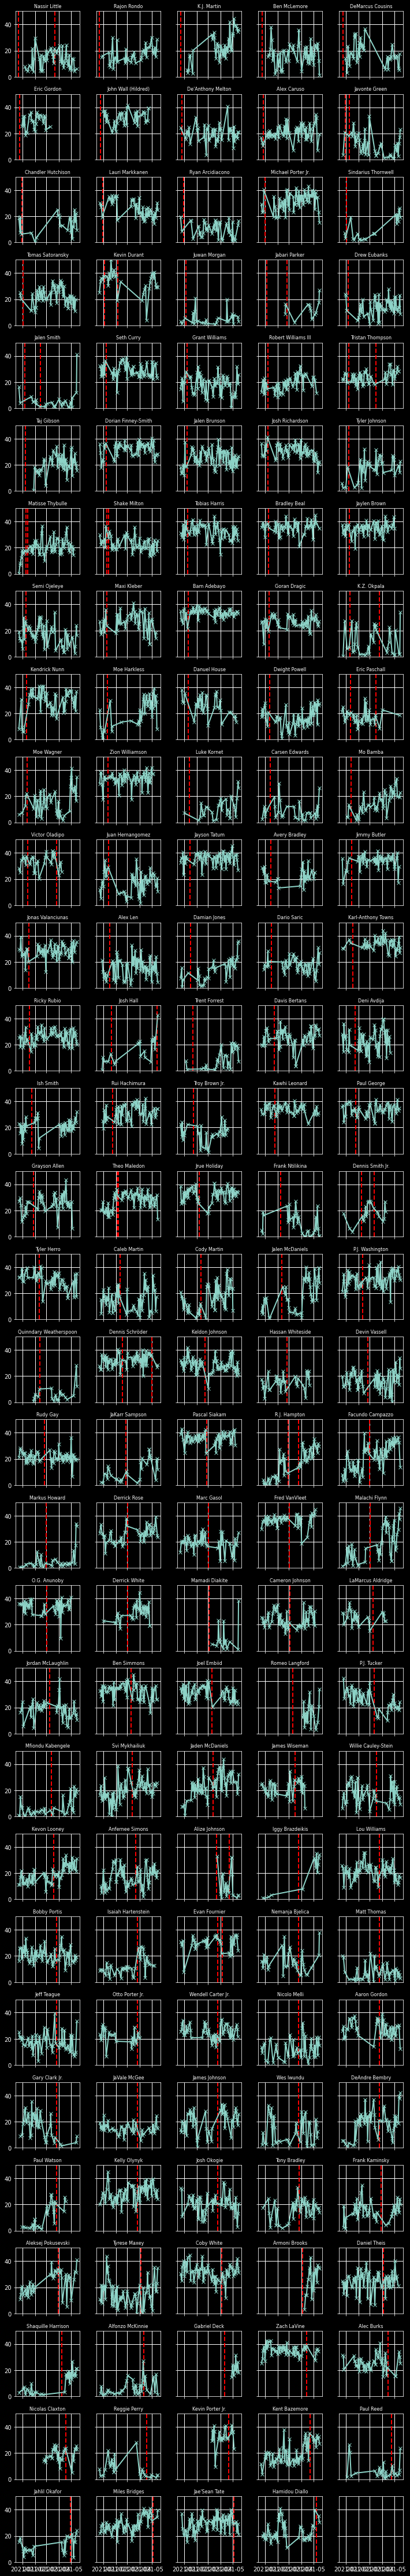

In [369]:
# for stat in gmlog_stats:
stat = 'MP'
fig, axs = plt.subplots(31,5, figsize=(10, 62), sharex=True, sharey=True)
max_y = 0
ax_flat = axs.flatten()
cntr = 0
# for ax, [player, bbrid] in zip(axs.flatten(), bbref_id_list):
for [player, bbrid] in bbref_id_list:
    gmlog_df = pd.read_json(f'../data/game_logs/{bbrid}_gamelog_2020_2021.txt').dropna()
    gmlog_df['MP'] = pd.to_datetime(gmlog_df['MP'], format='%M:%S')
    gmlog_df['MP'] = gmlog_df['MP'].dt.minute + gmlog_df['MP'].dt.second/60
    if gmlog_df['MP'].sum() > 100:
        if '/' in player:
            ax_flat[cntr].set_title(f"{player.split(' / ')[1]}", fontsize=8)
        else:
            ax_flat[cntr].set_title(f"{player}", fontsize=8)
        
        cv19dates = list(df_main_dates[df_main_dates['BBRef_ID'] == bbrid]['Date'])
        ax_flat[cntr].plot(gmlog_df['Date'], gmlog_df[stat], marker='x')
        player_max_y = gmlog_df[stat].max()
        if float(player_max_y) > max_y:
            max_y = player_max_y
        for cv19date in cv19dates:
            ax_flat[cntr].vlines(cv19date, 0, 50, color='red', ls='--')
        # print(f"{player} Plotted")
        cntr += 1
    else:
        # fig.delaxes(ax)
        print(f"{player} not Plotted")
# plt.xlim(dt(''))
plt.ylim([0, max_y])
fig.tight_layout()
print(f'Plotting {stat} Done, Saving Plot...')
fig.savefig(f'../img/{stat}_all_players')

In [365]:
154/5

30.8

In [517]:
selfid = 'duranke01'
year = 2021
# url = f'https://www.basketball-reference.com/players/{selfid[0]}/{selfid}/gamelog/{year}'
url='https://www.basketball-reference.com/players/d/duranke01/gamelog-playoffs/'
# pd.read_html(url)
df_list = pd.read_html(url)
playoffs_df = df_list[-1]
playoffs_df[playoffs_df[playoffs_df.columns[2]] == '2021 Playoffs']
# df_list[-1].loc[df_list[-1]['2021 Playoffs']]
# print(f"Number of tables found: {len(df_list)}") # Out: Number of tables found: 1

# r = requests.get(url)
# soup = BeautifulSoup(r.content, 'html.parser')
# soupList = []
# for row in soup.findAll('tr'):
#     for col in row.findAll('td'):
#         contents = list(col.stripped_strings)
#         if contents:
#             contentTd = contents[0]
#             # print "TD Number %d : %s" % (i, contentTd)
#             soupList.append(contentTd)
#             i += 1


,Rk,G,2010 Playoffs,Series,Tm,Unnamed: 5,Opp,G#,Unnamed: 8,GS,...,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,Unnamed: 31
178,Rk,G,2021 Playoffs,Series,Tm,NaN,Opp,G#,NaN,GS,...,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,NaN


In [485]:
soupList[-40:]

['.750',
 '1',
 '8',
 '9',
 '6',
 '0',
 '0',
 '5',
 '1',
 '12',
 '3.2',
 '+10',
 '35',
 '2021-05-16',
 '32-229',
 'BRK',
 'CLE',
 'W (+14)',
 '1',
 '28:55',
 '8',
 '10',
 '.800',
 '1',
 '2',
 '.500',
 '6',
 '6',
 '1.000',
 '0',
 '8',
 '8',
 '13',
 '0',
 '0',
 '2',
 '2',
 '23',
 '27.9',
 '+29']

3000